In [1]:
import datetime
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

In [3]:
from catboost import CatBoostRegressor
from pylab import rcParams
%matplotlib inline

#### 1). Загрузка тренировочного и тестового датасетов

In [4]:
TEST_DATASET_PATH = 'test.csv'
TRAIN_DATASET_PATH = 'train.csv'

In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH)
X_final = pd.read_csv(TEST_DATASET_PATH)

#### 2.) Уменьшение объёма потребляемой датасетом памяти
(путём оптимизации data type)

In [6]:
def optimize_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
df = optimize_mem_usage(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [8]:
X_final = optimize_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [9]:
X = df.drop('Price', axis=1)
y = df[['Price']]

preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне: ', X.shape[0])
print('Строк в тесте: ', X_final.shape[0])

del df
gc.collect()

Строк в трейне:  10000
Строк в тесте:  5000


4

#### 3). Анализ данных

In [10]:
X.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B
12915,59,3.0,80.384476,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B
14549,154,2.0,62.254112,37.160378,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B
11993,74,2.0,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
5172,1,2.0,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B


In [11]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
DistrictId,10000.0,50.400800,43.587592,0.000000,20.000000,36.000000,75.000000,2.090000e+02
Rooms,10000.0,1.890500,0.839512,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,10000.0,56.315777,21.058731,1.136859,41.774879,52.513309,65.900627,6.410652e+02
LifeSquare,7887.0,37.199646,86.241211,0.370619,22.769833,32.781261,45.128803,7.480592e+03
KitchenSquare,10000.0,6.273300,28.560917,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,10000.0,8.526700,5.241148,1.000000,4.000000,7.000000,12.000000,4.200000e+01
HouseFloor,10000.0,12.609400,6.775974,0.000000,9.000000,13.000000,17.000000,1.170000e+02
HouseYear,10000.0,3990.166300,200500.261427,1910.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,10000.0,0.118858,0.119025,0.000000,0.017647,0.075424,0.195781,5.218670e-01
Social_1,10000.0,24.687000,17.532614,0.000000,6.000000,25.000000,36.000000,7.400000e+01


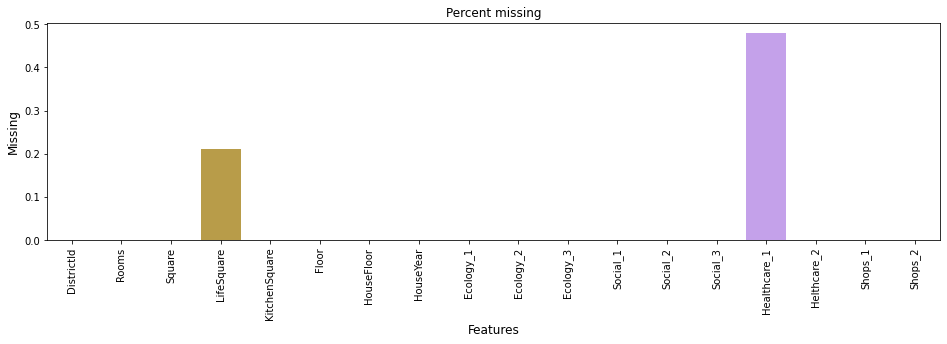

In [12]:
nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16, 4))
sns.barplot(x=nan_df['feature'], y=nan_df['nan_percent'])
plt.title('Percent missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

По статистикам видно, что некоторые основные числовые признаки (Rooms, KitchenSquare, HouseFloor) имеют нулевые значения, и много пропусков в признаках LifeSquare и Healthcare_1

In [13]:
for feat in ['Rooms', 'KitchenSquare', 'HouseFloor']:
    print(f'Количество наблюдений, где {feat}=0: {X.loc[(X[feat] == 0)].shape[0]}')

Количество наблюдений, где Rooms=0: 8
Количество наблюдений, где KitchenSquare=0: 697
Количество наблюдений, где HouseFloor=0: 269


In [14]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

In [15]:
X.dtypes

DistrictId         object
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

#### 4). Оценка выбросов

#### Выбросы по количеству комнат в квартирах

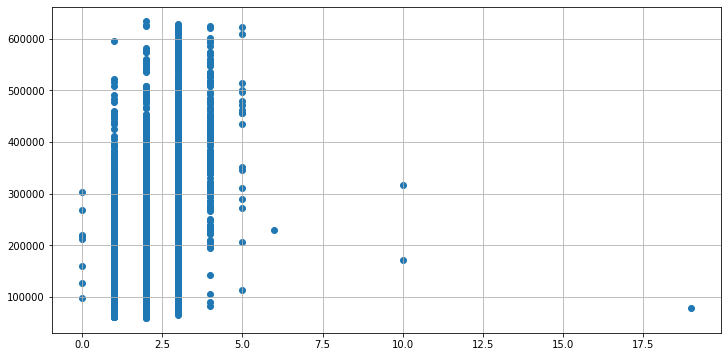

In [16]:
rcParams['figure.figsize'] = 12, 6
plt.scatter(X.Rooms, y)
plt.grid(True)

Можно принять, что количество комнат больше 5 и менее 1 это выбросы. Их нужно обработать.

#### Выбросы по площади квартир

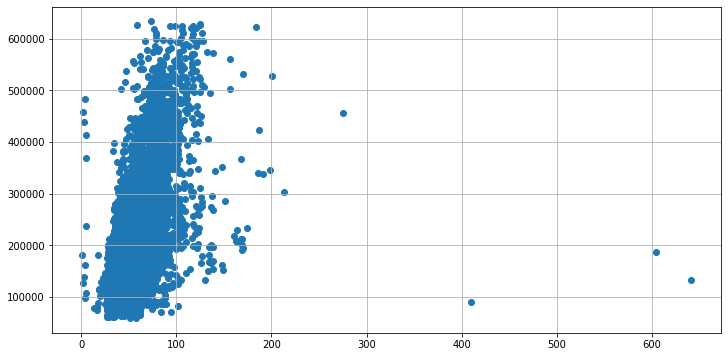

In [17]:
plt.scatter(X.Square, y)
plt.grid(True)

Значения менее 15 м2 и больше 250 м2 можно считать выбросом

#### Выбросы по площади кухни в квартире

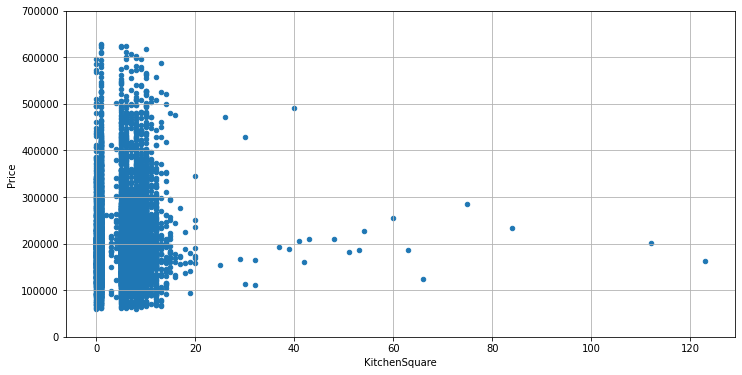

In [18]:
var = 'KitchenSquare'
data = pd.concat([y['Price'], X[var]], axis=1)
data.plot.scatter(x=var, y='Price', ylim=(0,700000))
plt.grid(True)

Значения менее 3 м2 и больше 25 м2 можно считать выбросом

In [19]:
X['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

In [20]:
X['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [21]:
(X['Floor'] > X['HouseFloor']).sum()

1825

In [22]:
X['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [23]:
X[X['HouseYear'] > 2020].head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
10814,109,1.0,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
11607,147,2.0,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [24]:
X.DistrictId.nunique()

205

In [25]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '47': 97,
 '13': 97,
 '101': 97,
 '99': 97,
 '7': 92,
 '48': 90,
 '29': 89,
 '94': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '37': 72,
 '90': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '128': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '119': 49,
 '111': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '129': 43,
 '63': 43,
 '124': 43,
 '79': 42,
 '42': 42,
 '109': 41,
 '113': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '56': 34,
 '32': 34,
 '5': 34,
 '103': 33,
 '123': 32,
 '33': 31,
 '80': 31,
 '83': 31,
 '19': 31,
 '130': 29,
 '138': 29,
 '69': 29,
 '64': 28,
 '70': 27,
 '108': 27,
 '87': 27,
 '86': 

#### 5). Обработка данных

In [26]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 6, 'KitchenSquare'] = 6
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = self.medians['HouseYear']
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
        
        # Lifesquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                    (~X['Square'].isna()) &\
                    (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        return X

In [27]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)
X_final = imputer.transform(X_final)

#### 6). Подготовка фичей для работы модели

In [28]:
class FeatureGenerator():
    """Генерация новых фичей"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictId
        district = X['DistrictId'].value_counts()
        district = district[district > 50]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict', 'DistrictId_popular':'DistrictId'})
            
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceByFloorYear'})
            
            
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X['Ecology_2'] = X['Ecology_2'].astype(int)
        X['Ecology_3'] = X['Ecology_3'].astype(int)
        X['Shops_2'] = X['Shops_2'].astype(int)
        
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
    
        return X
    
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[X['HouseYear'] > 2010, 'year_cat'] = 6
        
        return X

In [29]:
features = FeatureGenerator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [30]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictId_count,new_district,floor_cat,year_cat,MedPriceByDistrict,MedPriceByFloorYear
0,35,2.0,47.981560,29.442751,6.0,7.0,9.0,1969.0,0.089040,1,...,0,0,0,0,5.0,1,3.0,3.0,NaN,181784.53125
1,41,3.0,65.683640,40.049541,8.0,7.0,9.0,1978.0,0.000070,1,...,0,0,0,0,87.0,0,3.0,3.0,300009.437500,181784.53125
2,53,2.0,44.947952,29.197611,6.0,8.0,12.0,1968.0,0.049637,1,...,0,0,0,0,174.0,0,3.0,3.0,263206.218750,181784.53125
3,58,2.0,53.352982,52.731510,9.0,8.0,17.0,1977.0,0.437885,1,...,0,0,0,0,179.0,0,3.0,3.0,166809.671875,181784.53125
4,99,1.0,39.649193,23.776169,7.0,11.0,12.0,1976.0,0.012339,1,...,0,0,0,0,97.0,0,4.0,3.0,158539.062500,179775.81250


In [31]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier',
       'LifeSquare_nan', 'DistrictId_count', 'new_district', 'floor_cat',
       'year_cat', 'MedPriceByDistrict', 'MedPriceByFloorYear'],
      dtype='object')

In [32]:
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1', 
                  'HouseFloor_outlier', 'LifeSquare_nan', 'HouseFloor', 'HouseYear', 'DistrictId_count',
                   'Ecology_2', 'Ecology_3', 'Shops_2', 'MedPriceByDistrict', 'MedPriceByFloorYear']
# 'HouseYear_outlier', 'new_district', 'Rooms_outlier',
X = X[remain_features]
X_final = X_final[remain_features]

#### 7). Работа с моделью

In [33]:
model_2 = CatBoostRegressor(silent=True, learning_rate=0.1, iterations=1150, eval_metric='R2', depth=8)

model_2.fit(X, y)

cv_score = cross_val_score(model_2, X, y, scoring='r2', cv=KFold(n_splits=5, shuffle=True, random_state=42))

mean = cv_score.mean()
std = cv_score.std()
print('R2: {:.3f} +- {:.3f}'.format(mean, std))
# print(f'R2: {round(cv_score.mean(), 3)}')

R2: 0.745 +- 0.015


In [34]:
model_2.fit(X, y)

In [35]:
importances = model_2.feature_importances_
importances

array([ 2.06386698, 22.7414731 ,  5.11098645,  4.03937375,  3.2212482 ,
        7.53621373,  7.79904899,  4.75003905,  0.68493056,  0.26963119,
        4.35984569,  7.07777162, 15.59336365,  0.03706198,  0.1010575 ,
        0.39558582,  9.76732261,  4.45117912])

In [36]:
indices = np.argsort(importances)[::-1]
indices

array([ 1, 12, 16,  6,  5, 11,  2,  7, 17, 10,  3,  4,  0,  8, 15,  9, 14,
       13], dtype=int64)

In [37]:
importances[indices]

array([22.7414731 , 15.59336365,  9.76732261,  7.79904899,  7.53621373,
        7.07777162,  5.11098645,  4.75003905,  4.45117912,  4.35984569,
        4.03937375,  3.2212482 ,  2.06386698,  0.68493056,  0.39558582,
        0.26963119,  0.1010575 ,  0.03706198])

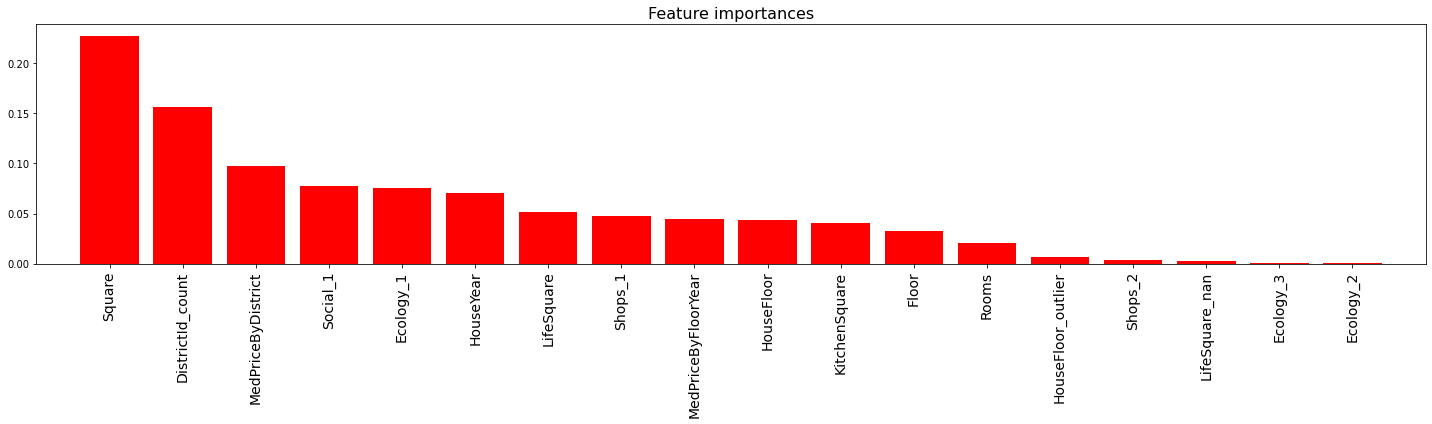

In [38]:
def plot_feature_importances(importances, X):
    
    importances = model_2.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize = (20, 6))
    plt.title('Feature importances', fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(), color='red', align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])
    
    plt.tight_layout()
    
    plt.show()
    
plot_feature_importances(importances = model_2.feature_importances_, X=X)

#### 8). Вывод и сохранение результата

In [39]:
y_pred_final = model_2.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions_11.csv', index=False)

preds_final.head()

,Id,Price
0,725,151075.927395
1,15856,233686.181818
2,5480,162408.781211
3,15664,329508.185594
4,14275,142442.326700


In [40]:
preds_final.shape

(5000, 2)